In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [2]:
# Install necessary libraries
!pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.2 MB/s eta 0:00:00


In [75]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import f1_score
from timm import create_model
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR

In [76]:
# Define constants
data_dir = '/content/drive/MyDrive/Univ/Semester 5/JST/CNN/'  # Replace with the actual path
batch_size = 16
learning_rate = 0.001
epochs = 8
image_size = (48, 48)  # Change this to the desired size

In [77]:
# Define data transformations with increased augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

In [78]:
# Load dataset
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)

In [79]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [80]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [81]:
# Define MobileNetV3 model
num_classes = 3
model = create_model('mobilenetv3_large_100', pretrained=True, num_classes=num_classes)
model.to(device)

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
 

In [82]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

In [84]:
# Lists to store training statistics
train_loss_history = []
accuracy_history = []

In [85]:
# Function to register hooks for feature extraction
def register_hooks(model):
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    hooks = []
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            hook = layer.register_forward_hook(hook_fn)
            hooks.append(hook)

    return activations, hooks

In [86]:
# Extract activations and register hooks
activations, hooks = register_hooks(model)
scaler = GradScaler()

In [87]:
# Training loop with mixed precision and LR scheduling
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Use autocast to enable mixed precision
        with autocast():
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Use scaler to perform backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Update learning rate
    scheduler.step()

    # Calculate accuracy and append to history
    accuracy = correct_predictions / total_samples
    accuracy_history.append(accuracy)

    # Print training loss, accuracy, and learning rate for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, LR: {scheduler.get_lr()[0]}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}')

    # Append loss to history
    train_loss_history.append(running_loss/len(train_loader))

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1/8, LR: 0.001, Loss: 5.432173750617287, Accuracy: 0.4003511852502195
Epoch 2/8, LR: 0.00025, Loss: 2.0680959158010417, Accuracy: 0.41044776119402987
Epoch 3/8, LR: 0.0005, Loss: 1.4305413973914993, Accuracy: 0.4288849868305531
Epoch 4/8, LR: 0.000125, Loss: 1.2811248031529514, Accuracy: 0.44029850746268656
Epoch 5/8, LR: 0.00025, Loss: 1.1338267993260096, Accuracy: 0.46005267778753295
Epoch 6/8, LR: 6.25e-05, Loss: 1.0700767098606883, Accuracy: 0.4929762949956102
Epoch 7/8, LR: 0.000125, Loss: 1.0460004823191182, Accuracy: 0.5004389815627743
Epoch 8/8, LR: 3.125e-05, Loss: 1.0035742087797686, Accuracy: 0.509657594381036


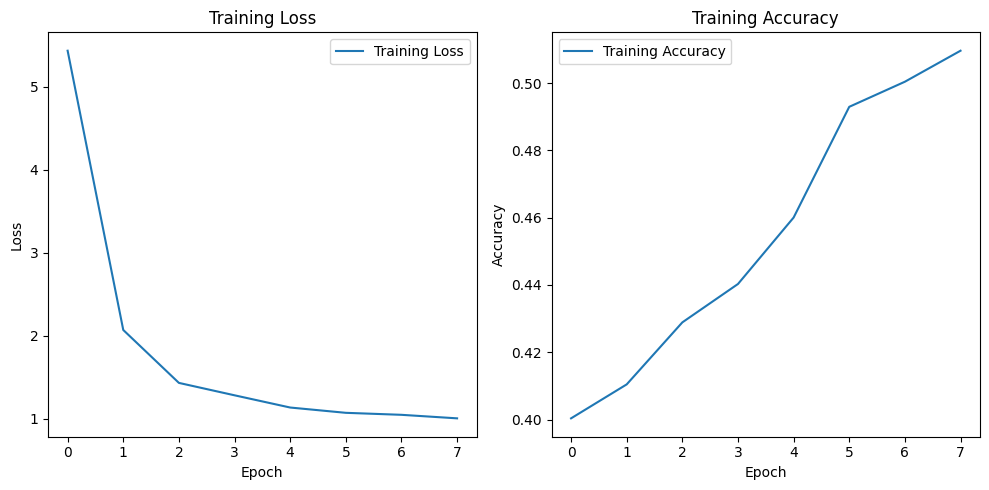

In [88]:
# Plot training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
# Visualize model architecture
#summary(model, (3, 48, 48), device=device)

In [90]:
# Visualize convolutional filters
# for i, activation in enumerate(activations):
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(activation[0, 0].cpu().detach().numpy(), cmap='viridis')
#     plt.title(f'Convolutional Filters - Layer {i + 1}')
#     plt.colorbar()

#     plt.subplot(1, 2, 2)
#     plt.imshow(inputs[0, 0].cpu().detach().numpy(), cmap='gray')
#     plt.title('Input Image')
#     plt.colorbar()

#     plt.show()

In [91]:
# Remove hooks
for hook in hooks:
    hook.remove()

In [92]:
# Fine-tuning loop
fine_tune_epochs = 4  # You can adjust this value
fine_tune_train_loss_history = []
fine_tune_accuracy_history = []

In [93]:
# Unfreeze certain layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

In [94]:
# Decrease the learning rate for fine-tuning
fine_tune_optimizer = optim.Adam(model.parameters(), lr=learning_rate / 10)

In [95]:
# Fine-tuning loop
for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Use autocast to enable mixed precision
        with autocast():
            fine_tune_optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Use scaler to perform backpropagation
        scaler.scale(loss).backward()
        scaler.step(fine_tune_optimizer)
        scaler.update()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate accuracy and append to history
    accuracy = correct_predictions / total_samples
    fine_tune_accuracy_history.append(accuracy)

    # Print training loss and accuracy for each epoch during fine-tuning
    print(f'Fine-tune Epoch {epoch + 1}/{fine_tune_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}')

    # Append loss to history
    fine_tune_train_loss_history.append(running_loss/len(train_loader))

Fine-tune Epoch 1/4, Loss: 1.0060713166123503, Accuracy: 0.5201931518876207
Fine-tune Epoch 2/4, Loss: 1.0139166000006081, Accuracy: 0.5074626865671642
Fine-tune Epoch 3/4, Loss: 1.0027255786882414, Accuracy: 0.5166812993854258
Fine-tune Epoch 4/4, Loss: 0.9759256898106395, Accuracy: 0.5324846356453029


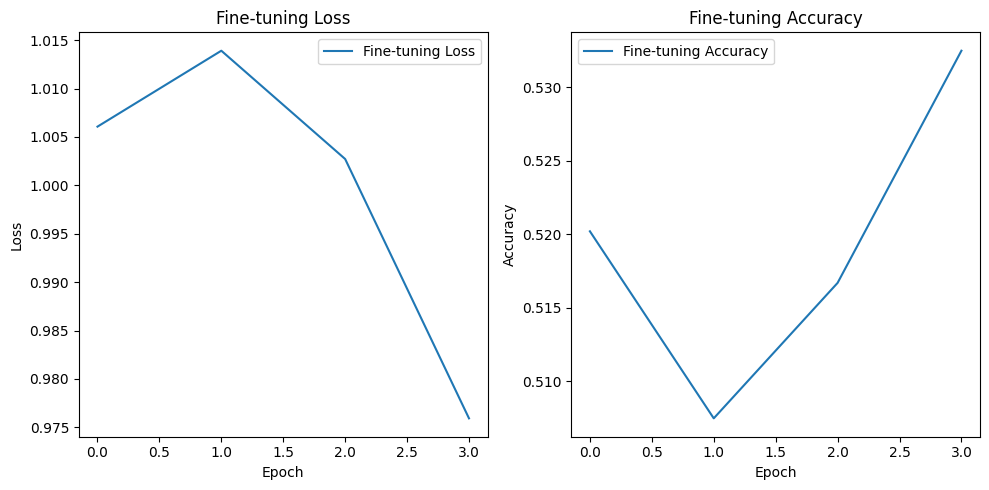

In [96]:
# Plot fine-tuning loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_train_loss_history, label='Fine-tuning Loss')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_accuracy_history, label='Fine-tuning Accuracy')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [97]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [98]:
import numpy as np

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [99]:
# Calculate metrics
accuracy = (all_preds == all_labels).mean()
f1 = f1_score(all_labels, all_preds, average='weighted')

In [100]:
# Print metrics
print(f'Test Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Test Accuracy: 0.5711775043936731
F1 Score: 0.56764777814661


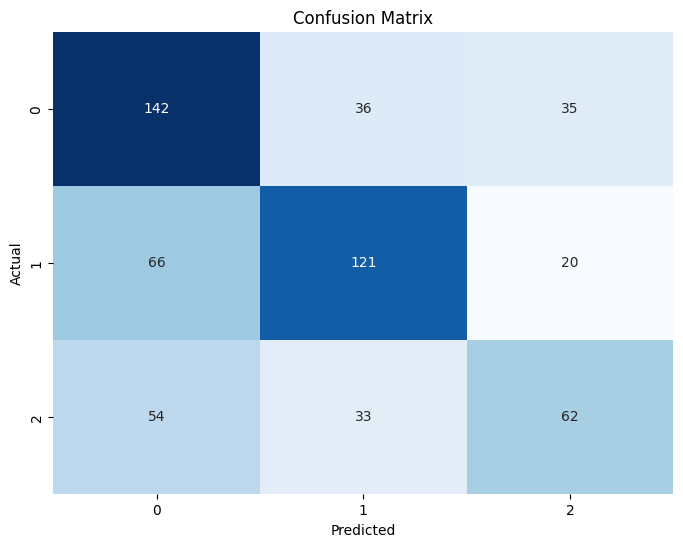

In [102]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [103]:
from sklearn.metrics import confusion_matrix, classification_report

# Print Classification Report
class_names = [str(i) for i in range(num_classes)]  # Replace with your actual class names
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.67      0.60       213
           1       0.64      0.58      0.61       207
           2       0.53      0.42      0.47       149

    accuracy                           0.57       569
   macro avg       0.57      0.56      0.56       569
weighted avg       0.57      0.57      0.57       569

